# Track changes in spectra through time

In [1]:
%pylab notebook

from datacube.storage import masking
from datacube.utils import geometry
from datacube import Datacube
import numpy as np
import fiona
import rasterio.features
import xarray as xr
import pandas as pd

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2dc = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')

Populating the interactive namespace from numpy and matplotlib


## Load in a shapefile of the field, and grab the geometry

In [2]:
shape_file = '/g/data/r78/cek156/ShapeFiles/CanolaField/Canola_field.shp'

In [3]:
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

## Load in the data for Sentinel 2a and mask it to only keep the field

In [4]:
query = {'geopolygon': geom,
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),         
         'time' : ('2017-05-01', '2017-12-31')
        }

Resolution10m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['blue', 'green', 'red', 'nir1', 'pixel_quality'], **query)

In [5]:
mask = rasterio.features.geometry_mask([geom.to_crs(Resolution10m.geobox.crs) for geoms in [geom]],
                                           out_shape=Resolution10m.geobox.shape,
                                           transform=Resolution10m.geobox.affine,
                                           all_touched=False,
                                           invert=True)
Resolution10mMasked = Resolution10m.where(mask)

In [6]:
query = {'geopolygon': geom,
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time' : ('2017-05-01', '2017-12-31')
        }

Resolution20m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['rededge1', 'rededge2', 'rededge3', 'nir2', 'swir1', 'swir2'], **query)

In [7]:
mask = rasterio.features.geometry_mask([geom.to_crs(Resolution20m.geobox.crs) for geoms in [geom]],
                                           out_shape=Resolution20m.geobox.shape,
                                           transform=Resolution20m.geobox.affine,
                                           all_touched=False,
                                           invert=True)
Resolution20mMasked = Resolution20m.where(mask)

In [8]:
query = {'geopolygon': geom,
        'output_crs': 'EPSG:3577',
        'resolution': (-60, 60),
         'time' : ('2017-05-01', '2017-12-31')
        }

Resolution60m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['aerosol'], **query)

In [9]:
mask = rasterio.features.geometry_mask([geom.to_crs(Resolution60m.geobox.crs) for geoms in [geom]],
                                           out_shape=Resolution60m.geobox.shape,
                                           transform=Resolution60m.geobox.affine,
                                           all_touched=False,
                                           invert=True)
Resolution60mMasked = Resolution60m.where(mask)

## Create field averages for each timestep

In [10]:
Field10m = Resolution10mMasked.groupby('time').mean()
Field20m = Resolution20mMasked.groupby('time').mean()
Field60m = Resolution60mMasked.groupby('time').mean()

## Filter out scenes with more than 50% missing data
Note that the masking adds some `NaN`s, so the threshold is actually lower than 50% of the field

In [11]:
acceptable_missing_data = 0.5

In [12]:
# Create boolean mask where the pixel quality flag == 1 (aka 'clear pixel')
PQmask = Resolution10mMasked.where(Resolution10mMasked.pixel_quality == 1)

In [13]:
# Find the total number of pixels in our scene * the acceptable_missing_data to find our threshold
threshold = Resolution10mMasked.x.count() * Resolution10mMasked.y.count() * acceptable_missing_data

# Apply the filter threshold to the 10m data
KeepTimeMask = PQmask.green.isnull().sum(axis=(1, 2))<= int(threshold)

In [14]:
Field10mFiltered = Field10m.where(KeepTimeMask).dropna(dim='time')
Field20mFiltered = Field20m.where(KeepTimeMask).dropna(dim='time')
Field60mFiltered = Field60m.where(KeepTimeMask).dropna(dim='time')

## Create our field spectra for each timestep

### Concatenate to create a spectra

In [15]:
Fieldspectra = xr.merge([Field10mFiltered, Field20mFiltered, Field60mFiltered])
Fieldspectra

<xarray.Dataset>
Dimensions:        (time: 13)
Coordinates:
  * time           (time) datetime64[ns] 2017-05-08T00:12:21.026000 ...
Data variables:
    blue           (time) float64 714.3 621.9 681.1 481.5 337.1 272.1 200.9 ...
    green          (time) float64 1.079e+03 878.7 919.7 777.3 611.8 532.0 ...
    red            (time) float64 1.565e+03 1.3e+03 1.269e+03 1.14e+03 654.9 ...
    nir1           (time) float64 2.354e+03 1.906e+03 1.994e+03 1.871e+03 ...
    pixel_quality  (time) float64 1.002 1.002 1.0 1.002 1.0 1.0 1.0 1.0 1.0 ...
    rededge1       (time) float64 1.881e+03 1.55e+03 1.551e+03 1.445e+03 ...
    rededge2       (time) float64 2.129e+03 1.693e+03 1.803e+03 1.69e+03 ...
    rededge3       (time) float64 2.199e+03 1.727e+03 1.844e+03 1.713e+03 ...
    nir2           (time) float64 2.486e+03 1.953e+03 2.093e+03 1.942e+03 ...
    swir1          (time) float64 3.95e+03 3.286e+03 3.305e+03 3.079e+03 ...
    swir2          (time) float64 3.613e+03 3.13e+03 2.948e+03 2.801

### Set up some labels for the different wavelengths

In [16]:
wavelengths = [443, 490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]
wavelengthlabels = ['aerosol', 'blue', 'green', 'red', 'rededge1', 'rededge2',
                    'rededge3', 'nir1', 'nir2', 'swir1', 'swir2']

### Pull the data into the required format

In [18]:
labels = np.tile(wavelengths, 13)
times = np.repeat(Fieldspectra.time.data, 11)
times = pd.to_datetime(times).strftime('%d-%m-%y')

spectraValues = np.zeros((13 * 11))
spectraValues[0::11] = Fieldspectra['aerosol'].values
spectraValues[1::11] = Fieldspectra['blue'].values
spectraValues[2::11] = Fieldspectra['green'].values
spectraValues[3::11] = Fieldspectra['red'].values
spectraValues[4::11] = Fieldspectra['rededge1'].values
spectraValues[5::11] = Fieldspectra['rededge2'].values
spectraValues[6::11] = Fieldspectra['rededge3'].values
spectraValues[7::11] = Fieldspectra['nir1'].values
spectraValues[8::11] = Fieldspectra['nir2'].values
spectraValues[9::11] = Fieldspectra['swir1'].values
spectraValues[10::11] = Fieldspectra['swir2'].values

### Put it all into a pandas dataframe (required by Seaborn)

In [19]:
df = pd.DataFrame(dict(spectraValues=spectraValues, times=times))
df['labels'] = labels

## Plot

<IPython.core.display.Javascript object>


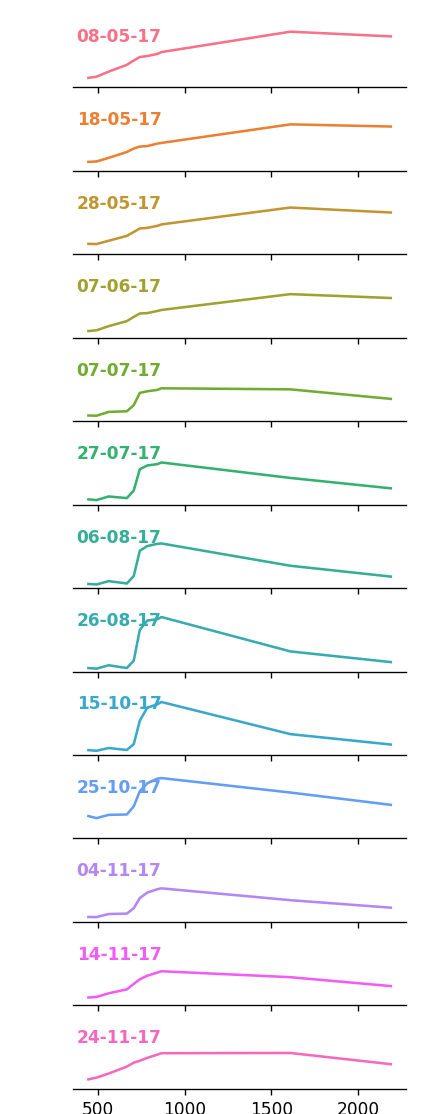

In [20]:
import seaborn as sns

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="times", hue="times", aspect=5, size=0.7)
g.map(plt.plot,'labels', 'spectraValues')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .8, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

# Set the subplots to overlap
g.fig.tight_layout()
    
g.map(label, "times")

g.set(yticks=[])
g.set_titles("")
g.despine(left=True)

savefig('CanolaSpectra.jpg')